# Seguimiento de la opinión pública usando MCMC:
## Elecciones presidenciales 2021

Alonso Rojas, Tiare Letelier

## Primera vuelta

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import dirichlet, gamma

### Datos:

In [6]:
#pip install openpyxl

In [7]:
df = pd.read_excel('Datosfinal.xlsx', sheet_name='Datos_por_dia') #Cambiar por el archivo de datos de encuestas electorales
print(df)

                   FECHA  ENCUESTADOR    N  KAST  SICHEL  BORIC  PROVOSTE
0    2021-02-01 00:00:00            0    0     0       0      0         0
1    2021-02-02 00:00:00            0    0     0       0      0         0
2    2021-02-03 00:00:00            0    0     0       0      0         0
3    2021-02-04 00:00:00            0    0     0       0      0         0
4    2021-02-05 00:00:00            3  704    14      28      7         0
..                   ...          ...  ...   ...     ...    ...       ...
281  2021-11-17 00:00:00            0    0     0       0      0         0
282  2021-11-18 00:00:00            0    0     0       0      0         0
283  2021-11-19 00:00:00            0    0     0       0      0         0
284  2021-11-20 00:00:00            0    0     0       0      0         0
285  2021-11-21 00:00:00            0    0     0       0      0         0

[286 rows x 7 columns]


In [12]:
datos2021 = df.to_numpy()[189:, 3:] #se filtran los datos relevantes (candidatos y encuestas no tan antiguas)
datos2021 = np.array(datos2021, dtype=int)
print(datos2021)


[[ 302  668  523  242]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [ 357  463  612  379]
 [ 124  295  388  186]
 [  43  159  188   87]
 [   0    0    0    0]
 [  84  133  161   84]
 [   0    0    0    0]
 [   0    0    0    0]
 [ 178  291  437  178]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [  63  134  155   71]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [  72  162  216   90]
 [  85  145  211   76]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [ 222  294  438  169]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0

### Modelo 1:
Distribución de prueba: $Gamma(500\times\alpha_{ti}+y_{ti}, 1)$

In [13]:
#modelo1: array, int -> array, array
#se realizará un seguimiento de la intención de voto aplicado al caso de las elecciones
#presidenciales del año 2021 (se recomienda ver la presentacion del proyecto)
#retorna un array muestra que contiene la informacion de la distribucion de todos los dias, para cada iteracion (iteracion,dia,cand)
def modelo1(data, N):
    post = lambda p, alpha: dirichlet.logpdf(p, alpha) #distribucion a posteriori
    prueba = lambda alpha: np.array([gamma.rvs(a) for a in alpha]) #se puede cambiar el tipo de distribucion para samplear
    days = np.size(data, 0) #cantidad de dias
    cand = np.size(data, 1) #cantidad de candidatos
    muestra = np.zeros((N, days, cand))
    prior = np.full(cand, 1/cand) #en la iteracion 0 se elige una prior uniforme
    c = np.zeros(days)
    for i in range(N): #en cada iteracion cambiamos las distribuciones de todos los dias
        for day in range(days):
            if day == 0:
                p = prior 
            else:
                p = muestra[i, day-1]
            y = data[day] #resultados en el dia enesimo (array de votos por candidato)
            alpha = y + 500 * p
            p_prueba = prueba(alpha) #se samplea una distribucion de la gamma con los datos del dia anterior
            p_prueba = p_prueba / p_prueba.sum() #normalizamos
            metrop = post(p_prueba, alpha) - post(p, alpha) 
            #Se transiciona con la idea de Metropolis Hasting
            if min(metrop, 0) > np.log(np.random.uniform()): # se transiciona con probabilidad 
                muestra[i, day] = p_prueba
                c[day] += 1
            else:
                muestra[i, day] = p #en caso contrario nos quedamos con la distribucion pasada (en el dia t-1)
    return muestra, c

In [25]:
np.random.seed(567) #se fija una semilla
muestra1, c1 = modelo1(datos2021, 10_000)
muestra1 = muestra1[1000::100] #filtramos datos

In [72]:
prop = muestra1.mean(0)
days = np.size(prop, 0)
q = [0.05, 0.95]
q1, q2 = np.quantile(muestra1, q, axis=0) #construimos un quantil para englobar a los datos no extremos (un 5% son <=q1, el otro es analogo)
for i in range(days):
    print('aceptados dia {}: {:%}'.format(i+1, c1[i]/10_000)) #muestra la cantidad de veces (en %) que se transiciono ese dia

aceptados dia 1: 100.000000%
aceptados dia 2: 35.500000%
aceptados dia 3: 35.460000%
aceptados dia 4: 36.080000%
aceptados dia 5: 35.480000%
aceptados dia 6: 36.550000%
aceptados dia 7: 35.450000%
aceptados dia 8: 35.300000%
aceptados dia 9: 35.950000%
aceptados dia 10: 35.730000%
aceptados dia 11: 35.050000%
aceptados dia 12: 35.150000%
aceptados dia 13: 35.020000%
aceptados dia 14: 35.930000%
aceptados dia 15: 99.940000%
aceptados dia 16: 100.000000%
aceptados dia 17: 96.970000%
aceptados dia 18: 35.870000%
aceptados dia 19: 94.630000%
aceptados dia 20: 36.470000%
aceptados dia 21: 35.510000%
aceptados dia 22: 95.260000%
aceptados dia 23: 36.010000%
aceptados dia 24: 35.830000%
aceptados dia 25: 35.420000%
aceptados dia 26: 68.050000%
aceptados dia 27: 35.720000%
aceptados dia 28: 35.910000%
aceptados dia 29: 35.070000%
aceptados dia 30: 73.220000%
aceptados dia 31: 72.780000%
aceptados dia 32: 35.550000%
aceptados dia 33: 35.580000%
aceptados dia 34: 35.720000%
aceptados dia 35: 35.

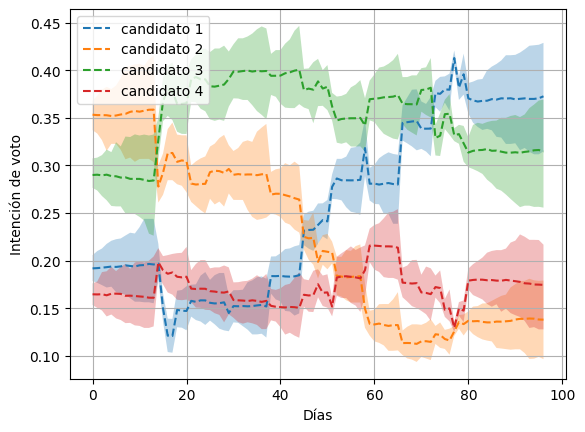

In [10]:
for i in range(4):
    plt.plot(range(days), prop[:,i], '--', label= 'candidato {}'.format(i+1))
    plt.fill_between(range(days), q1[:,i], q2[:,i],alpha=0.3) #ponemos el quantil de la data
plt.xlabel("Días")
plt.ylabel("Intención de voto")
plt.grid()
plt.legend();

In [12]:
#se printea el valor del ultimo dia obtenido por el algoritmo
pred = prop[-1]
print('Kast: {:%}'.format(pred[0]))
print('Sichel: {:%}'.format(pred[1]))
print('Boric: {:%}'.format(pred[2]))
print('Provoste: {:%}'.format(pred[3]))

Kast: 37.258136%
Sichel: 13.813335%
Boric: 31.462617%
Provoste: 17.465911%


### Modelo 2:
Distribución de prueba: $Unif(\max\{(500\alpha_{t-1,i}+y_{ti})-d,0\},(500\alpha_{t-1,i}+y_{ti})+d)$
(discreta)

In [45]:
#modelo2: array, int, int -> array, array
#se realizará un seguimiento de la intención de voto aplicado al caso de las elecciones
#presidenciales del año 2021 (se recomienda ver la presentacion del proyecto)
#retorna un array muestra que contiene la informacion de la distribucion de todos los dias, para cada iteracion (iteracion,dia,cand)
def modelo2(data, N, d):
    post = lambda p, alpha: dirichlet.logpdf(p, alpha) #distribucion a posteriori
    days = np.size(data, axis=0)
    cand = np.size(data, axis=1)
    prueba = lambda alpha, d: np.random.randint(np.maximum(alpha-d,0),alpha+d, size=cand) #se puede cambiar el tipo de distribucion para samplear
    muestra = np.zeros((N, days, cand))
    prior = np.full(cand, 1/cand) #en la iteracion 0 se elige una prior uniforme
    c = np.zeros(days)
    for i in range(N): #en cada iteracion cambiamos las distribuciones de todos los dias
        for day in range(days):
            if day == 0:
                p = prior
            else:
                p = muestra[i, day-1]
            y = data[day] #resultados en el dia enesimo (array de votos por candidato)
            alpha = 500 * p + y
            p_prueba = prueba(alpha, d) #se samplea una distribucion de la gamma con los datos del dia anterior
            p_prueba = p_prueba/p_prueba.sum() #normalizamos
            #Se transiciona con la idea de Metropolis Hasting
            if post(p_prueba, alpha) - post(p, alpha) > np.log(np.random.uniform()): # se transiciona con probabilidad 
                muestra[i, day] = p_prueba
                c[day] += 1
            else:
                muestra[i, day] = p #en caso contrario nos quedamos con la distribucion pasada (en el dia t-1)
    return muestra, c

$d=50$

In [46]:
np.random.seed(834)
muestra2, c2 = modelo2(datos2021, 10_000, d=50) #se puede variar d y ver diferencias (se hace mas abajo con d`s representativos)
muestra2 = muestra2[1000::100]

In [47]:
prop = muestra2.mean(0)
days = np.size(prop, 0)
q = [0.05, 0.95]
q1, q2 = np.quantile(muestra2, q, axis=0) #construimos un quantil para englobar a los datos no extremos (un 5% son <=q1, el otro es analogo)
for i in range(days):
    print('aceptados dia {}: {:%}'.format(i+1, c2[i]/10_000)) #muestra la cantidad de veces (en %) que se transiciono ese dia

aceptados dia 1: 100.000000%
aceptados dia 2: 2.750000%
aceptados dia 3: 2.620000%
aceptados dia 4: 2.810000%
aceptados dia 5: 2.520000%
aceptados dia 6: 2.650000%
aceptados dia 7: 2.750000%
aceptados dia 8: 2.300000%
aceptados dia 9: 2.660000%
aceptados dia 10: 2.880000%
aceptados dia 11: 2.760000%
aceptados dia 12: 2.800000%
aceptados dia 13: 2.690000%
aceptados dia 14: 2.900000%
aceptados dia 15: 100.000000%
aceptados dia 16: 99.600000%
aceptados dia 17: 42.780000%
aceptados dia 18: 2.140000%
aceptados dia 19: 31.830000%
aceptados dia 20: 2.580000%
aceptados dia 21: 2.390000%
aceptados dia 22: 80.580000%
aceptados dia 23: 2.560000%
aceptados dia 24: 2.350000%
aceptados dia 25: 2.310000%
aceptados dia 26: 14.360000%
aceptados dia 27: 2.790000%
aceptados dia 28: 2.450000%
aceptados dia 29: 2.290000%
aceptados dia 30: 19.300000%
aceptados dia 31: 18.530000%
aceptados dia 32: 2.280000%
aceptados dia 33: 2.360000%
aceptados dia 34: 2.230000%
aceptados dia 35: 2.680000%
aceptados dia 36: 

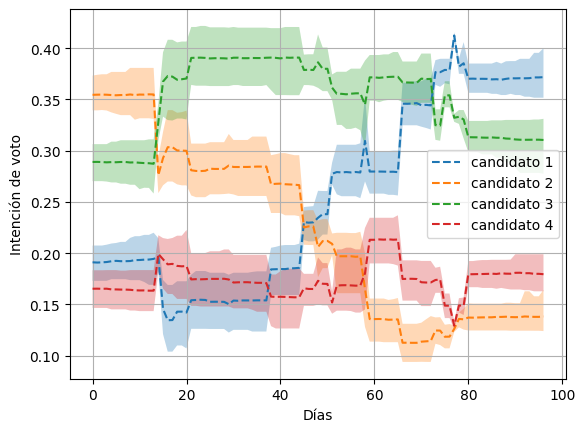

In [48]:
for i in range(4):
    plt.plot(range(days), prop[:,i], '--', label= 'candidato {}'.format(i+1))
    plt.fill_between(range(days), q1[:,i], q2[:,i],alpha=0.3) #ponemos el quantil de la data
plt.xlabel("Días")
plt.ylabel("Intención de voto")
plt.grid()
plt.legend();

In [49]:
#se printea el valor del ultimo dia obtenido por el algoritmo
pred = prop[-1]
print('Kast: {:%}'.format(pred[0]))
print('Sichel: {:%}'.format(pred[1]))
print('Boric: {:%}'.format(pred[2]))
print('Provoste: {:%}'.format(pred[3]))

Kast: 37.180306%
Sichel: 13.823127%
Boric: 31.049486%
Provoste: 17.947081%


$d=10$

In [51]:
np.random.seed(834)
muestra3, c3 = modelo2(datos2021, 10_000, d=10) #el unico cambio es d=10, lo demas es analogo
muestra3 = muestra3[1000::100]

In [52]:
prop = muestra3.mean(0)
days = np.size(prop, 0)
q = [0.05, 0.95]
q1, q2 = np.quantile(muestra3, q, axis=0)
for i in range(days):
    print('aceptados dia {}: {:%}'.format(i+1, c3[i]/10_000))

aceptados dia 1: 100.000000%
aceptados dia 2: 65.680000%
aceptados dia 3: 65.390000%
aceptados dia 4: 65.960000%
aceptados dia 5: 64.860000%
aceptados dia 6: 65.610000%
aceptados dia 7: 65.470000%
aceptados dia 8: 65.160000%
aceptados dia 9: 63.620000%
aceptados dia 10: 65.110000%
aceptados dia 11: 64.880000%
aceptados dia 12: 65.040000%
aceptados dia 13: 64.750000%
aceptados dia 14: 65.150000%
aceptados dia 15: 100.000000%
aceptados dia 16: 100.000000%
aceptados dia 17: 100.000000%
aceptados dia 18: 62.200000%
aceptados dia 19: 100.000000%
aceptados dia 20: 63.910000%
aceptados dia 21: 64.110000%
aceptados dia 22: 99.990000%
aceptados dia 23: 64.410000%
aceptados dia 24: 65.200000%
aceptados dia 25: 64.640000%
aceptados dia 26: 99.380000%
aceptados dia 27: 64.140000%
aceptados dia 28: 63.990000%
aceptados dia 29: 62.470000%
aceptados dia 30: 98.580000%
aceptados dia 31: 99.690000%
aceptados dia 32: 62.980000%
aceptados dia 33: 63.630000%
aceptados dia 34: 62.760000%
aceptados dia 35: 

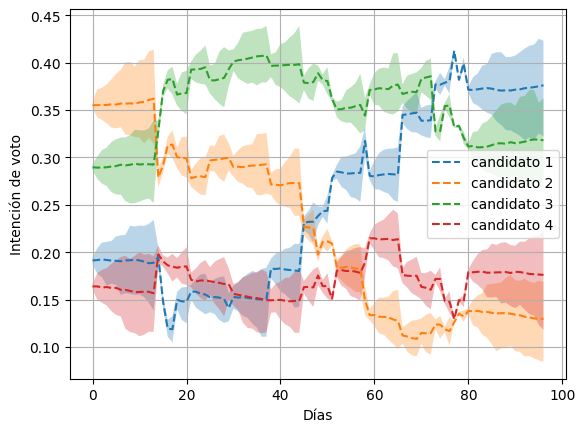

In [53]:
for i in range(4):
    plt.plot(range(days), prop[:,i], '--', label= 'candidato {}'.format(i+1))
    plt.fill_between(range(days), q1[:,i], q2[:,i],alpha=0.3)
plt.xlabel("Días")
plt.ylabel("Intención de voto")
plt.grid()
plt.legend();

In [54]:
pred = prop[-1]
print('Kast: {:%}'.format(pred[0]))
print('Sichel: {:%}'.format(pred[1]))
print('Boric: {:%}'.format(pred[2]))
print('Provoste: {:%}'.format(pred[3]))

Kast: 37.610321%
Sichel: 12.962773%
Boric: 31.818190%
Provoste: 17.608716%


$d=25$

In [55]:
np.random.seed(834)
muestra4, c4 = modelo2(datos2021, 10_000, d=25) #d=25
muestra4 = muestra4[1000::100]

In [56]:
prop = muestra4.mean(0)
days = np.size(prop, 0)
q = [0.05, 0.95]
q1, q2 = np.quantile(muestra4, q, axis=0)
for i in range(days):
    print('aceptados dia {}: {:%}'.format(i+1, c4[i]/10_000))

aceptados dia 1: 100.000000%
aceptados dia 2: 16.610000%
aceptados dia 3: 16.160000%
aceptados dia 4: 15.710000%
aceptados dia 5: 15.950000%
aceptados dia 6: 16.400000%
aceptados dia 7: 16.260000%
aceptados dia 8: 15.440000%
aceptados dia 9: 15.470000%
aceptados dia 10: 15.860000%
aceptados dia 11: 15.070000%
aceptados dia 12: 15.890000%
aceptados dia 13: 15.550000%
aceptados dia 14: 16.540000%
aceptados dia 15: 100.000000%
aceptados dia 16: 100.000000%
aceptados dia 17: 97.980000%
aceptados dia 18: 13.580000%
aceptados dia 19: 95.140000%
aceptados dia 20: 15.270000%
aceptados dia 21: 15.130000%
aceptados dia 22: 98.970000%
aceptados dia 23: 14.240000%
aceptados dia 24: 14.810000%
aceptados dia 25: 14.870000%
aceptados dia 26: 59.470000%
aceptados dia 27: 14.680000%
aceptados dia 28: 14.710000%
aceptados dia 29: 14.680000%
aceptados dia 30: 68.540000%
aceptados dia 31: 68.650000%
aceptados dia 32: 14.400000%
aceptados dia 33: 14.370000%
aceptados dia 34: 14.790000%
aceptados dia 35: 14

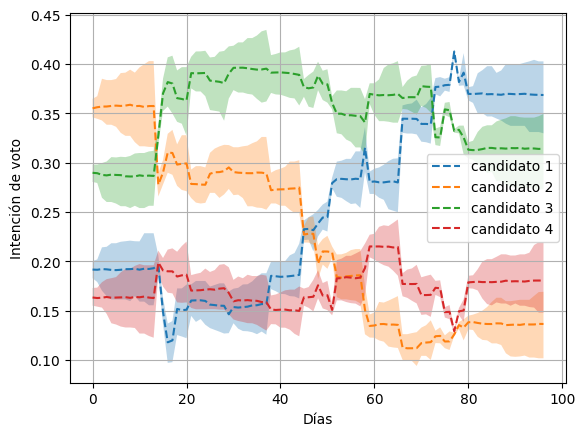

In [57]:
for i in range(4):
    plt.plot(range(days), prop[:,i], '--', label= 'candidato {}'.format(i+1))
    plt.fill_between(range(days), q1[:,i], q2[:,i],alpha=0.3)
plt.xlabel("Días")
plt.ylabel("Intención de voto")
plt.grid()
plt.legend();

In [58]:
pred = prop[-1]
print('Kast: {:%}'.format(pred[0]))
print('Sichel: {:%}'.format(pred[1]))
print('Boric: {:%}'.format(pred[2]))
print('Provoste: {:%}'.format(pred[3]))

Kast: 36.859793%
Sichel: 13.660811%
Boric: 31.416833%
Provoste: 18.062562%


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d24ecb2b-b17d-41bb-82ac-38080033d82c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>